In [1]:
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, BatchNormalization, \
    LeakyReLU, Reshape, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.optimizer_v2.adam import Adam

2021-08-12 14:53:35.371608: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(f"Tensorflow: {tensorflow.__version__}")
print(f"Keras: {tensorflow.keras.__version__}")

Tensorflow: 2.5.1
Keras: 2.5.0


In [3]:
def get_discriminator(input_size=(250, 450, 3)):
    model = Sequential()

    model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_size))
    model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [4]:
def get_generator(input_dim=100):
    gen_input = Input(input_dim)
    init = LeakyReLU()(BatchNormalization()(Dense(16 * 29 * 1024, input_dim=input_dim, use_bias=False)(gen_input)))
    init = Reshape((16, 29, 1024))(init)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(init)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=3)([up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up1 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up3 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    output = Resizing(height=250, width=450)(conv9)
    model = Model(inputs=[gen_input], outputs=[output])

    model.compile(optimizer=Adam(learning_rate=3e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
def get_gan(disc, gen):
    disc.trainable = False
    model = Sequential(name="generator")
    model.add(gen)
    model.add(disc)
    opt = Adam(learning_rate=2e-4, beta_1=0.05)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
generator = get_generator()
generator.summary()

2021-08-12 14:53:41.617988: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-12 14:53:41.666743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 14:53:41.667311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.392GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2021-08-12 14:53:41.667339: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-12 14:53:41.669942: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-12 14:53:41.669993: I tensorflow/stream_executor/p

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 475136)       47513600    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 475136)       1900544     dense[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 475136)       0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
disc = get_discriminator()
disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 250, 450, 64)      1792      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 250, 450, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 225, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 125, 225, 128)     73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 125, 225, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 112, 128)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 62, 112, 256)      2

In [8]:
gan = get_gan(disc, generator)
gan.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 250, 450, 3)       70232003  
_________________________________________________________________
sequential (Sequential)      (None, 1)                 9835073   
Total params: 80,067,076
Trainable params: 69,281,731
Non-trainable params: 10,785,345
_________________________________________________________________


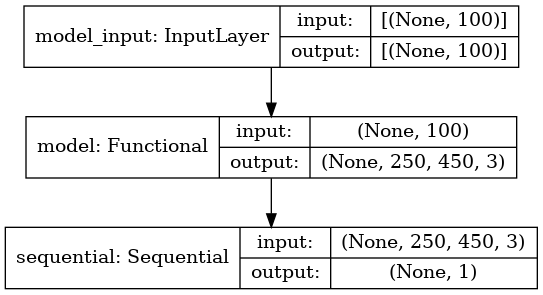

In [9]:
plot_model(disc, "discriminator.png", show_shapes=True)
plot_model(generator, "generator.png", show_shapes=True)
plot_model(gan, "gan.png", show_shapes=True)